In [ ]:
!nvidia-smi

Wed Jun  1 15:08:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# mount driver
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CardiacSeg/SwinUNETR_SegTHOR

# # install torch by gpu version
# !pip install -q torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

# # install dependents
# !pip install -q monailabel-weekly
# !pip install -q "monai-weekly[nibabel, tqdm, einops]"
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1jz_DGnICBmKWCr_JL904PDQdIEK0_EQG/CardiacSeg/SwinUNETR_SegTHOR


In [ ]:
!pip install -q monailabel-weekly

In [60]:
import os
from pathlib import PurePath
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from monai.utils import first
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    ToNumpyd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    LabelFilterd,
    MapLabelValued,
    SaveImaged,
    ToDeviced,
    EnsureTyped,
    SqueezeDimd
)


from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    TestTimeAugmentation
)

from monai.transforms.utils import allow_missing_keys_mode

import torch
from torch.utils.tensorboard import SummaryWriter

import pandas as pd

In [ ]:
class Config:
  model_name = 'crop_foreground'
  use_pretrained_model = True
  root_dir = './'
  model_dir = os.path.join(root_dir, 'models', model_name)
  pretrained_model_pth = os.path.join(model_dir, 'dc_96_best_metric_model.pth')
  img_pth = r'../dataset/corcta/corcta.nii.gz'

config = Config

data = {
  'image': config.img_pth,
}

print(data)

{'image': '../dataset/corcta/corcta.nii.gz'}


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("cuda is available")
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    print("cuda is not available")
    device = torch.device("cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=2,
    feature_size=48,
    use_checkpoint=True,
).to(device)

cuda is available


In [ ]:
use_pretrained_model = config.use_pretrained_model
pretrained_model_pth = config.pretrained_model_pth
if use_pretrained_model:
  model.load_state_dict(
      torch.load(
          pretrained_model_pth,
          map_location=device
      )
  )
  print(f'load pretrained model: {pretrained_model_pth}')
else:
  print(f'not load pretrained model')

load pretrained model: ./models/crop_foreground/dc_96_best_metric_model.pth


In [ ]:
pre_transforms = Compose([
    LoadImaged(keys=["image"]),
    AddChanneld(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(
        keys=["image"],
        pixdim=(1.5, 1.5, 2.0),
        mode=("bilinear"),
    ),
    ScaleIntensityRanged(
        keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
    ),
    AddChanneld(keys=["image"]),
    ToTensord(keys=["image"]),
    ToDeviced(keys=["image"], device=device),

])

post_transforms = Compose([
    Orientationd(keys=["pred"], axcodes="LPS"),
    ToNumpyd(keys=["pred"]),
    # SaveImaged(keys=["pred"])
])

In [63]:
def infer_seg(images, model):
    model.eval()
    with torch.no_grad():
      pred = sliding_window_inference(images, (96, 96, 96), 4, model, overlap=0.8)
      pred = torch.argmax(pred,dim=1)
      return pred

In [71]:
transformed_data = pre_transforms(data)

In [75]:
transformed_data = pre_transforms(data)
seg = infer_seg(transformed_data["image"].to(device), model).detach().cpu()[0]
seg_dict = {"image": seg, "image_transforms": transformed_data["image_transforms"]}
with allow_missing_keys_mode(pre_transforms):
    inverted_seg = pre_transforms.inverse(seg_dict)

None of the inputs have requires_grad=True. Gradients will be None


RuntimeError: ignored

In [72]:
transformed_data.keys()

dict_keys(['image', 'pred', 'image_meta_dict', 'image_transforms'])

In [ ]:
def infer(data, model, pre_transforms, post_transforms):
  model.eval()
  with torch.no_grad():
      pred = sliding_window_inference(pre_transforms(data)['image'], (96, 96, 96), 4, model, overlap=0.8)
      data['pred'] = torch.argmax(pred,dim=1)
      # # plt.imshow(pred.cpu().detach().numpy()[0,:,:,40])
      print(data.keys())
      # data = post_transforms(data)
      # plt.imshow(data['pred'][0,:,:,40])

In [ ]:
infer(data, model, pre_transforms, post_transforms)

None of the inputs have requires_grad=True. Gradients will be None


dict_keys(['image', 'pred'])


In [47]:
t = Compose([
    AddChanneld(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(
        keys=["image"],
        pixdim=(1.5, 1.5, 2.0),
        mode=("bilinear"),
    ),
    ScaleIntensityRanged(
        keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
    ),
    SqueezeDimd(keys=["image"])
])

In [46]:
LoadImaged(keys=["image"])(data)['image']

array([[[ -945.,  -946.,  -944., ...,  -997., -1002., -1008.],
        [ -946.,  -947.,  -942., ...,  -999., -1004., -1007.],
        [ -937.,  -935.,  -932., ..., -1002., -1001., -1001.],
        ...,
        [ -831.,  -791.,  -723., ...,  -820.,  -814.,  -800.],
        [ -816.,  -707.,  -566., ...,  -820.,  -809.,  -781.],
        [ -775.,  -608.,  -381., ...,  -823.,  -812.,  -800.]],

       [[ -951.,  -950.,  -947., ..., -1001., -1003., -1007.],
        [ -948.,  -950.,  -946., ..., -1003., -1001., -1004.],
        [ -944.,  -941.,  -938., ..., -1003.,  -996., -1002.],
        ...,
        [ -825.,  -790.,  -727., ...,  -820.,  -812.,  -802.],
        [ -808.,  -722.,  -636., ...,  -821.,  -808.,  -787.],
        [ -776.,  -644.,  -522., ...,  -819.,  -812.,  -797.]],

       [[ -954.,  -951.,  -944., ..., -1010., -1005., -1008.],
        [ -952.,  -948.,  -944., ..., -1010., -1001., -1001.],
        [ -949.,  -948.,  -939., ..., -1002.,  -991.,  -994.],
        ...,
        [ -8

In [55]:
d = LoadImaged(keys=["image"])(data)

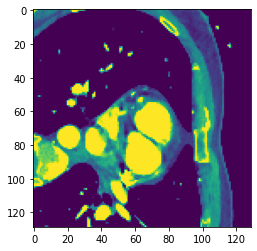

In [56]:
data_tr = t(d)
plt.imshow(data_tr['image'][:,:,50])

In [57]:
data_inv = t.inverse(data_tr)
plt.imshow(data_inv['image'][:,:,50])

RuntimeError: ignored